<a href="https://colab.research.google.com/github/urchymanny/machine-learning-and-ai/blob/main/05_TensorFlow_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow --quiet
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-16 20:22:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-16 20:22:19 (138 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augumentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode="categorical", # what type are the labels?
                                          batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = image_dataset_from_directory(directory=test_dir,
                                        image_size=IMG_SIZE,
                                        label_mode="categorical")


--2024-04-16 20:22:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.3MB/s    in 4.1s    

2024-04-16 20:22:24 (38.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
from tensorflow import keras

In [5]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")

data_augumentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
])

# start by augumenting the data
x = data_augumentation(inputs)

# pass aug data into base base model as input
x = base_model(x, training=False)

# pool after data has passed through base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)

# create the output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# create the model
model = tf.keras.Model(inputs, outputs)

# create a checkpoint callback

checkpoint_path = "tmp/checkpoint.ckpt"

ckp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

initial_epoch = 5

history = model.fit(
    train_data,
    epochs=initial_epoch,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[ckp_callback]
)

24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0248 - accuracy: 0.3173
Epoch 1: val_loss improved from inf to 1.48549, saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 24s 616ms/step - loss: 2.0248 - accuracy: 0.3173 - val_loss: 1.4855 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4033 - accuracy: 0.6387
Epoch 2: val_loss improved from 1.48549 to 1.04607, saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 9s 362ms/step - loss: 1.4033 - accuracy: 0.6387 - val_loss: 1.0461 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1226 - accuracy: 0.7253
Epoch 3: val_loss improved from 1.04607 to 0.86069, saving model to tmp/checkpoint.ckpt
24/24 [==============================] - 9s 356ms/step - loss: 1.1226 - accuracy: 0.7253 - val_loss: 0.8607 - val_accuracy: 0.7911
Ep

# Finetuning

In [6]:
# For finetuning, we need to unfreeze some layers in the base_model

base_model.trainable = True

# freeze all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False


model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [7]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [8]:
len(model.trainable_variables)

12

In [9]:
fine_tune_epochs = initial_epoch + 5

# refit the model (with more trainable variables) and start off where the last fitting ended
history_2 = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch = history.epoch[-1], # added to start off where the last model fitting ended
)

Epoch 5/10
24/24 [==============================] - 18s 410ms/step - loss: 0.7133 - accuracy: 0.7867 - val_loss: 0.5111 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 6s 256ms/step - loss: 0.4781 - accuracy: 0.8520 - val_loss: 0.4986 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 7s 265ms/step - loss: 0.3311 - accuracy: 0.8960 - val_loss: 0.4603 - val_accuracy: 0.8635
Epoch 8/10
24/24 [==============================] - 6s 244ms/step - loss: 0.2716 - accuracy: 0.9200 - val_loss: 0.4067 - val_accuracy: 0.8783
Epoch 9/10
24/24 [==============================] - 7s 272ms/step - loss: 0.2099 - accuracy: 0.9293 - val_loss: 0.4291 - val_accuracy: 0.8799
Epoch 10/10
24/24 [==============================] - 6s 247ms/step - loss: 0.1733 - accuracy: 0.9493 - val_loss: 0.4405 - val_accuracy: 0.8668


In [10]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3173333406448364, 0.6386666893959045, 0.7253333330154419, 0.7773333191871643, 0.7839999794960022, 0.7866666913032532, 0.8519999980926514, 0.8960000276565552, 0.9200000166893005, 0.9293333292007446, 0.9493333101272583]


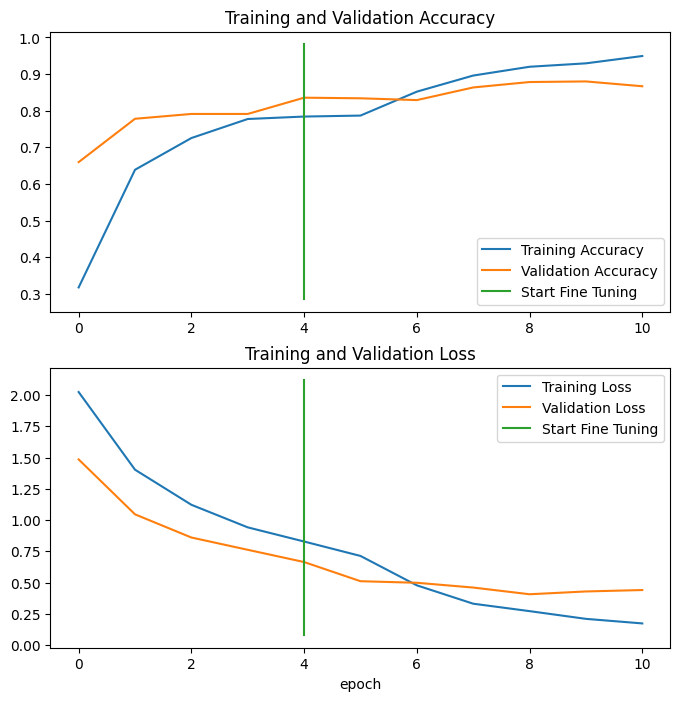

In [11]:
compare_historys(history, history_2)

# Model 4: Finetuning existing model with 100% of the data

In [12]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

# Create training and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode="categorical", # what type are the labels?
                                          batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = image_dataset_from_directory(directory=test_dir,
                                        image_size=IMG_SIZE,
                                        label_mode="categorical")

--2024-04-16 20:24:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  40.3MB/s    in 13s     

2024-04-16 20:24:35 (37.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [14]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [15]:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 31ms/step - loss: 0.6613 - accuracy: 0.8308


[0.661338210105896, 0.8307999968528748]

In [24]:
# make the last 10 trainable
for layer in model_2.layers[2].layers[-10:]:
  layer.trainable = True

block6h_se_reduce
block6h_se_expand
block6h_se_excite
block6h_project_conv
block6h_project_bn
block6h_drop
block6h_add
top_conv
top_bn
top_activation


In [25]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [26]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.optimizers.Adam(learning_rate=0.0001), # us 10x less lr for fine tuning
    metrics=["accuracy"]
)

In [29]:
fine_tune_epochs = initial_epoch + 5

history_4 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        initial_epoch=history.epoch[-1],
                        validation_steps=int(0.25 * len(test_data))
)

Epoch 5/10
235/235 [==============================] - 49s 190ms/step - loss: 0.8870 - accuracy: 0.7471 - val_loss: 0.5881 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 35s 150ms/step - loss: 0.8248 - accuracy: 0.7616 - val_loss: 0.5401 - val_accuracy: 0.8635
Epoch 7/10
235/235 [==============================] - 30s 128ms/step - loss: 0.7827 - accuracy: 0.7721 - val_loss: 0.5119 - val_accuracy: 0.8569
Epoch 8/10
235/235 [==============================] - 28s 120ms/step - loss: 0.7526 - accuracy: 0.7775 - val_loss: 0.4720 - val_accuracy: 0.8668
Epoch 9/10
235/235 [==============================] - 25s 107ms/step - loss: 0.7219 - accuracy: 0.7877 - val_loss: 0.4615 - val_accuracy: 0.8668
Epoch 10/10
235/235 [==============================] - 23s 99ms/step - loss: 0.7026 - accuracy: 0.7924 - val_loss: 0.4545 - val_accuracy: 0.8701


In [30]:
model_2.evaluate(test_data)

79/79 [==============================] - 2s 25ms/step - loss: 0.4398 - accuracy: 0.8732


[0.43980932235717773, 0.873199999332428]